# SVHN Classification

This notebook focuses on classifying the Street View House Numbers dataset using the following techniques: SVM, random forest / ensemble, linear regression, and k-nearest neighbors. The image set can be found at http://ufldl.stanford.edu/housenumbers/.

## Preprocessing

The following preprocessing techniques were used: Reshaping the dataset, converting RGB to grayscale, scaling the data, and undersampling the training data to achieve an even distribution among classes.

In [ ]:
# import libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
import io
from PIL import Image
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn import datasets
from sklearn.metrics import accuracy_score
from scipy.io import loadmat
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from skimage import color
from skimage.feature import hog
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import h5py

We load in the datasets using loadmat, and preprocess the data.

In [7]:
# format 2
tr_set = "C:/Users/Ups/Desktop/Street View ML Project Datasets/train_32x32.mat"
te_set = "C:/Users/Ups/Desktop/Street View ML Project Datasets/test_32x32.mat"
ex_set = "C:/Users/Ups/Desktop/Street View ML Project Datasets/extra_32x32.mat"

In [8]:
# format 2 load-in
data = loadmat(tr_set)
te_data = loadmat(te_set)

X_tr, y_tr = data['X'], data['y']
X_te, y_te = te_data['X'], te_data['y']


In [9]:
# training data details
print ("Training Set Shape Params: <width, height, channels [rgb], # of images>")
print("X Shape: ", X_tr.shape, " y Shape: ", y_tr.shape)

Training Set Shape Params: <width, height, channels [rgb], # of images>
X Shape:  (32, 32, 3, 73257)  y Shape:  (73257, 1)


In [10]:
# transpose data to (# of images, width, height, rgb)
X_tr, y_tr = X_tr.transpose((3,0,1,2)), y_tr[:,0]
X_te, y_te = X_te.transpose((3,0,1,2)), y_te[:,0]

In [11]:
# convert RGB to grayscale
def rgb2gray(img_data):
    return np.expand_dims(np.dot(img_data, [0.3, 0.6, 0.1]), axis=3)

X_tr_gr = rgb2gray(X_tr).astype(np.float32) # converts gray training set to float values
X_te_gr = rgb2gray(X_te).astype(np.float32)

X_tr = X_tr_gr # replace original training set
X_te = X_te_gr
print("Training Set", X_tr.shape)

Training Set (73257, 32, 32, 1)


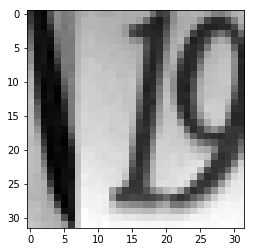

In [12]:
digit_img = X_tr[0].reshape((32,32))
plt.imshow(digit_img, cmap='gray')
plt.show()

In [13]:
X_tr_resized = X_tr.reshape(73257, 32*32*1)
X_te_resized = X_te.reshape(26032, 32*32*1)

In [14]:
sc_X = StandardScaler()
X_tr_scaled = sc_X.fit_transform(X_tr_resized)
X_te_scaled = sc_X.transform(X_te_resized)

In [45]:
X_tr_scaled.shape

(73257, 1024)

In [16]:

from sklearn.datasets import make_classification


In [17]:
from imblearn.under_sampling import RandomUnderSampler

In [18]:
X_tr.shape

(73257, 32, 32, 1)

In [19]:
y_tr.shape

(73257,)

In [22]:
from collections import Counter
Counter(y_tr)

Counter({1: 13861,
         9: 4659,
         2: 10585,
         3: 8497,
         5: 6882,
         8: 5045,
         7: 5595,
         4: 7458,
         6: 5727,
         10: 4948})

The distribution of the images seem to be much more biased towards 1, 2, and 3. So we undersample the data to match label 10. We could also oversample to match 1 using the extra image set, but processing speed would take a hit.

In [23]:
rus = RandomUnderSampler(random_state=42)

In [25]:
X_tr_undersmp, y_tr_undersmp = rus.fit_resample(X_tr_resized, y_tr)

In [27]:
X_tr_undersmp.shape

(46590, 1024)

## Hyperparameter Searching and Predictions

We fit various models here, and compare test accuracies. We use random search for random forest, and grid search for SVC to find optimal parameters, but search time is quite significant (10+ hours). We also make several predictions on the test set using different hyperparameters.

In [227]:
rf_noPCA = RandomForestClassifier(n_estimators=1500, oob_score=True, random_state=42, min_samples_leaf=1, max_features="auto")

In [228]:
rf_noPCA.fit(X_tr_undersmp, y_tr_undersmp)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1500,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [229]:
rf_noPCA_prediction = rf_noPCA.predict(X_tr_undersmp)

In [230]:
# accuracy of no PCA random forest w/ undersampled data
accuracy_score(y_tr_undersmp,rf_noPCA_prediction)

1.0

In [231]:
# test set prediction
test_noPCA = rf_noPCA.predict(X_te_resized)
print(test_noPCA)
accuracy_score(y_te, test_noPCA)

[5 2 1 ... 7 6 7]


0.7149661954517517

Random forest without PCA -> 71% accuracy

Now we search for optimal hyperparameters for the random forest algorithm using 3-fold cross validation.

In [66]:
# random search for optimal parameters of random forest
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [500,700,900]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [1,5,10]
# Minimum number of samples required to split a node
min_samples_split = [3,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [67]:
random_grid

{'n_estimators': [500, 700, 900],
 'max_features': ['auto'],
 'max_depth': [1, 5, 10],
 'min_samples_split': [3, 5],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [68]:
rf = RandomForestClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_tr_undersmp, y_tr_undersmp)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 48.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 171.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 318.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [72]:
rf_random.best_params_

{'n_estimators': 900,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [73]:
new_rfc = RandomForestClassifier(criterion='entropy', min_samples_split = 5, min_samples_leaf = 1, random_state=42, max_depth=10, max_features='auto', n_estimators=900, bootstrap = False)

In [74]:
new_rfc.fit(X_tr_undersmp, y_tr_undersmp)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=900,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [75]:
new_predictRf = new_rfc.predict(X_tr_undersmp)
accuracy_score(y_tr_undersmp, new_predictRf)

0.8170852114187593

In [76]:
new_predictRf_te = new_rfc.predict(X_te_resized)
accuracy_score(y_te, new_predictRf_te)

0.6389443761524278

The new hyperparameters used after searching achieved a lower test accuracy of 64% in comparison with the previous hyperparameters.

Now we will use a K-nearest neighbors model to predict on the test data, after applying principal component analysis on the training data.

In [42]:
from sklearn.decomposition import PCA

In [47]:
X_tr_scaled = sc_X.fit_transform(X_tr_undersmp)
X_te_scaled = sc_X.transform(X_te_resized)

In [48]:
pca = PCA(0.95)
X_tr_new = pca.fit_transform(X_tr_undersmp)
X_te_new = pca.transform(X_te_resized)

In [56]:
from sklearn.neighbors import KNeighborsClassifier
# train KNN classifier
knn = KNeighborsClassifier(n_neighbors=2)

In [57]:
knn.fit(X_tr_new, y_tr_undersmp) ## train knn on PCA data

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [58]:
knn_pred_tr = knn.predict(X_tr_new)

In [59]:
accuracy_score(y_tr_undersmp, knn_pred_tr)

0.7340201760034342

In [61]:
# test set prediction
knn_pred_te = knn.predict(X_te_new)

In [62]:
accuracy_score(y_te, knn_pred_te)

0.45636140135218195

KNN produces a test accuracy of 45.6%.

In [93]:
# try SVM w/ PCA and kernel trick
# grid search for params
svc_grid = SVC(random_state=42)

param_grid = { 
    'gamma': [0.00001, 0.0001, 0.01],
    'C': [1, 10]
}

svc_grid = GridSearchCV(svc_grid, param_grid, cv = 5)

In [96]:
svc_grid.fit(X_tr_new, y_tr_undersmp)
svc_grid.best_params_

{'C': 10, 'gamma': 1e-05}

In [249]:
svc = SVC(kernel='rbf', gamma=0.000001, C=10, random_state=42)

In [250]:
svc.fit(X_tr_new, y_tr_undersmp)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-06, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [251]:
svc_predict = svc.predict(X_tr_new)
accuracy_score(y_tr_undersmp, svc_predict)

0.9655720111611934

In [252]:
svc_predict_te = svc.predict(X_te_new)
accuracy_score(y_te, svc_predict_te)

0.7115473263675476

SVM with parameters gamma = 0.000001 and C = 10 has 71% accuracy. Setting gamma to 0.0000001 however decreases the accuracy, down to 43%.

In [253]:
confusion_matrix(y_te,svc_predict_te)

array([[3875,  159,  242,  199,   69,  122,  151,   96,   95,   91],
       [ 176, 3001,  201,  127,   80,   81,  187,  111,  126,   59],
       [ 201,  116, 1700,   62,  188,   51,  102,  122,  290,   50],
       [  77,   39,   40, 2015,   20,  122,   24,   57,   74,   55],
       [  76,   43,  162,   62, 1561,  167,   37,  121,   97,   58],
       [  44,   22,   22,  143,   83, 1372,   17,  121,   39,  114],
       [ 125,  124,   57,   12,   26,   38, 1558,   12,   48,   19],
       [  53,   44,   56,   63,   62,  178,   19, 1030,   93,   62],
       [  40,   50,   41,   30,   44,   37,   30,   66, 1164,   93],
       [  24,   39,   59,   41,   33,  110,   42,   52,   97, 1247]],
      dtype=int64)

In [247]:
y_te
svc_predict_te

array([5, 2, 1, ..., 7, 6, 7], dtype=uint8)

Here, we will train a logistic regression model using parameters {solver = 'lbfgs', and multi_clas = 'ovr'}.

In [208]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, solver = 'lbfgs', multi_class='ovr').fit(X_tr_new, y_tr_undersmp)

C:\Users\Ups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [205]:
log_pred = log_reg.predict(X_te_new)

In [206]:
accuracy_score(y_te, log_pred)

0.1687922556853104

Very low accuracy (17%) when using logistic regression.

We will now try ensemble learning (stacking) using SVC and Random Forest to increase prediction accuracy on the testing set. We choose to not include logistic regression or K-nearest neighbors in the ensemble, as they performed poorly on the testing set individually.

In [232]:
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('SVC', svc), ('RF', rf_noPCA)], voting='hard')
voting_clf.fit(X_tr_new, y_tr_undersmp)

VotingClassifier(estimators=[('SVC',
                              SVC(C=100, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma=1e-06, kernel='rbf',
                                  max_iter=-1, probability=False,
                                  random_state=42, shrinking=True, tol=0.001,
                                  verbose=False)),
                             ('RF',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,


In [233]:
voting_pred = voting_clf.predict(X_te_new)

In [234]:
accuracy_score(y_te, voting_pred)

0.7074754148740012

In [235]:
confusion_matrix(y_te, voting_pred)

array([[4372,  130,  149,  151,   41,   67,  109,   32,   33,   15],
       [ 313, 3185,  165,  132,   63,   53,  140,   38,   48,   12],
       [ 343,  242, 1701,   91,  134,   37,   94,   51,  169,   20],
       [ 161,   88,   70, 2045,   20,   58,   24,   13,   25,   19],
       [ 140,   90,  266,  133, 1505,  101,   36,   44,   51,   18],
       [  88,   62,   88,  251,  145, 1225,   12,   45,   21,   40],
       [ 181,  169,   77,   34,   35,   37, 1463,    5,   13,    5],
       [  87,   87,   83,  143,   87,  234,   25,  839,   50,   25],
       [  69,   81,   78,   65,   62,   39,   49,   67, 1047,   38],
       [  55,   67,   81,   84,   46,  128,   60,   67,  121, 1035]],
      dtype=int64)

Stacking both SVC and Random Forest gives us a slightly lower accuracy of 70.7%. 

## Conclusion

Out of the tested models: Random Forest, SVC (RBF), Linear Regression, KNN, and a stacked ensemble of SVC + Random Forest, it appears that Random Forest attained the highest test accuracy of ~71.5%, followed closely by SVC with ~71.2%, and the stacked ensemble with ~70.7%. The changes made to the original training set were: converting RGB to grayscale, undersampling classes to achieve an even distribution among all 10 classes, principal component analysis (to decrease runtime), and scalar standardization.